In [37]:
import pandas as pd
from scipy.stats import f_oneway, ttest_ind

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [165]:
df = pd.read_excel("processed/msamogh-turn-durations-seconds.xlsx")
df["turn_durations"] = df["turn_durations"].apply(eval)

In [166]:
len(df)

301

In [167]:
df["num_turns"] = df["turn_durations"].apply(lambda x: max(map(int, x.keys())))

[0.4539247173800581, 0.05892768943936695, 0.5205466112664648]
[0.16047071239758187, 0.05561782962814438, 0.7009762275778668, 0.10003113235983133]
[0.22615428846535301, 0.774690127526494, 0.014059263688308446, 0.0030105315724473247, 0.0045119636600172075]
[0.14288721572387297, 0.00438191297513708, 0.45304170021522727, 0.032577903930847335, 0.36202127485387603, 0.015814082375674977]
[0.21106495386579993, 0.021326258780452318, 0.32409033047796065, 0.03382625871747413, 0.277896780179225, 0.012338079502790993, 0.14371429173617997]
[0.06924630139086686, 0.041382773279012804, 0.2677151514602321, 0.09394086913357427, 0.42811596004195807, 0.01431267464002983, 0.09248922569704038, 0.004626006270142132]
[0.04097631911473675, 0.06104198556115203, 0.27641538932339155, 0.0444575784951283, 0.23375781316769426, 0.11303054868426217, 0.2016583074935495, 0.030191917329003764, 0.005586634148086006]
[0.1308175197318397, 0.13435702279889106, 0.22836092764714225, 0.003904651827365145, 0.20376544347494088, 0.

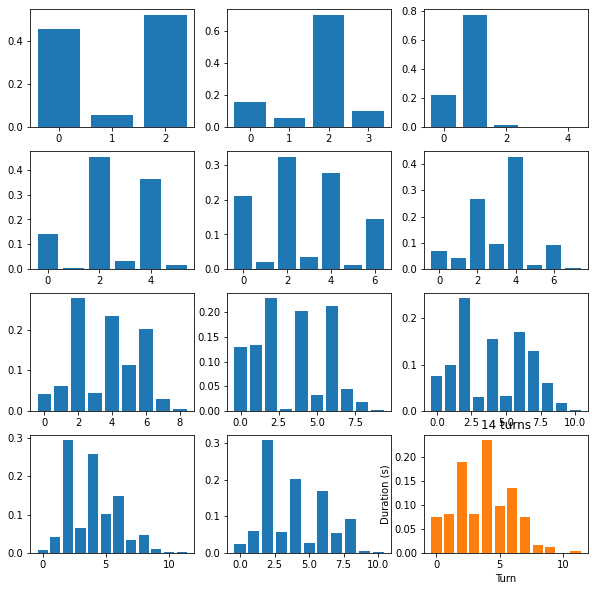

In [168]:
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from functools import reduce
turn_durations = defaultdict(float)

def cum_turn_duration(turn_durations):
    result = defaultdict(float)
    for turn_duration in turn_durations:
        for turn, duration in turn_duration.items():
            result[int(turn)] += duration
        for turn, duration in turn_duration.items():
            result[int(turn)] /= sum(turn_duration.values())
    # Normalize per turn
    # for k, v in result.items():
    #     result[k] = v / sum(result.values())
    return list(map(lambda x: x[1], sorted(result.items(), key=lambda x: x[0])))

length_wise_turn_durations = df.groupby("num_turns")["turn_durations"].agg(cum_turn_duration)
fig, axs = plt.subplots(nrows=len(length_wise_turn_durations) // 3, ncols=3, figsize=(10, 10))

for idx, ax in zip(length_wise_turn_durations.index, axs.ravel()):
    print(length_wise_turn_durations[idx])
    ax.bar(list(range(len(length_wise_turn_durations[idx]))), length_wise_turn_durations[idx])
    plt.title(f"{idx} turns")
    plt.xlabel("Turn")
    plt.ylabel("Duration (s)")
    plt.bar(range(len(turn_durations)), turn_durations)
# length_wise_turn_durations

In [169]:
# Filter only dialogues with < 6 turns
df = df[df["turn_durations"].apply(lambda x: max(map(float, x.keys())) < 9)]
len(df)

186

In [93]:
df["norm_turn"] = df["turn_durations"].apply(lambda x: {(float(turn) + 1) / (max(map(float, x)) + 1): duration for turn, duration in x.items()})

In [94]:
df["early"] = df["norm_turn"].apply(lambda x: sum([duration for turn, duration in x.items() if turn <= 1/3]))
df["mid"] = df["norm_turn"].apply(lambda x: sum([duration for turn, duration in x.items() if turn > 1/3 and turn <= 2/3]))
df["late"] = df["norm_turn"].apply(lambda x: sum([duration for turn, duration in x.items() if turn >= 2/3]))

df["total_duration"] = df["norm_turn"].apply(lambda x: sum([duration for _, duration in x.items()]))
df["early_norm"] = df["early"] / df["total_duration"]
df["mid_norm"] = df["mid"] / df["total_duration"]
df["late_norm"] = df["late"] / df["total_duration"]

In [95]:
df[["early", "mid", "late"]].describe()

,early,mid,late
count,76.000000,76.000000,76.000000
mean,20.566013,23.215132,26.248829
std,20.085115,19.618805,18.782852
min,0.000000,0.701000,0.092000
25%,7.432250,9.180000,11.699500
50%,15.478000,19.399000,23.850000
75%,24.388751,32.273250,38.891000
max,112.582000,101.865000,76.360999


In [96]:
df[["early_norm", "mid_norm", "late_norm"]].describe()

,early_norm,mid_norm,late_norm
count,76.000000,76.000000,76.000000
mean,0.310346,0.335017,0.407902
std,0.221830,0.207848,0.234534
min,0.000000,0.007845,0.000775
25%,0.169950,0.226206,0.239801
50%,0.259484,0.334678,0.426438
75%,0.412615,0.443170,0.551810
max,0.970593,0.953282,0.959441


In [97]:
f_oneway(df["early_norm"], df["mid_norm"], df["late_norm"])

F_onewayResult(statistic=3.9794791816529824, pvalue=0.020026221446931485)

In [33]:
ttest_ind(df["early_norm"], df["mid_norm"])

Ttest_indResult(statistic=0.8350623487823995, pvalue=0.40401498289916693)

In [55]:
ttest_ind(df["mid_norm"], df["late_norm"])

Ttest_indResult(statistic=7.47511753760392, pvalue=2.745530940604959e-13)

In [57]:
ttest_ind(df["early_norm"], df["late_norm"])

Ttest_indResult(statistic=7.580740189640346, pvalue=1.3114195164263693e-13)

In [51]:
# df = df[["prompt", "early_norm", "mid_norm", "late_norm"]]
# df["prompt"] = df["prompt"].apply(lambda x: {"semi": 0, "goal": 1}[x])
# model = ols('prompt ~ C(early_norm) + C(mid_norm) + C(late_norm) + C(early_norm):C(mid_norm) + C(early_norm):C(late_norm) + C(mid_norm):C(late_norm)', data=df).fit()
# sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(early_norm),7.521036e+01,297.0,8.355548e+26,5.736309e-41
C(mid_norm),7.447059e+01,294.0,8.357785e+26,5.734153e-41
C(late_norm),7.715210e+01,297.0,8.571268e+26,5.521122e-41
Residual,9.092169e-28,3.0,NaN,NaN
